# Lab 2

- Bmad/Tao/PyTao into
- Designing periodic Twiss

In [1]:
from pytao import Tao

import numpy as np

import matplotlib.pyplot as plt

# Helpers

In [2]:
def write_str(string, filename):
    with open(filename, 'w') as f:
        f.write(string)

## Basic FODO lattice in Bmad

In [3]:
Lquad = 0.1
Ltot = 2

LAT = f"""
parameter[geometry] = closed
beginning[e_tot] = 100e6

Ltot = {Ltot}
Lquad = {Lquad}

! Drifts
d1: drift, L = Ltot/2 - Lquad
d2: d1

! Quads
q1: quad, L = Lquad, k1 = 1
q2: q1, k1 = -q1[k1]

lat: line = (d1, q1, 
            d2, q2)

use, lat

"""

write_str(LAT, 'lat.bmad')

In [4]:
tao = Tao('-lat lat.bmad')

In [5]:
%%tao
sho ele end

-------------------------
Tao> sho ele end
Element # 5
Element Name: END
Key: Marker
S_start, S:      2.000000,      2.000000
Ref_time_start, Ref_time:  6.671369E-09,  6.671369E-09

Attribute values [Only non-zero values shown]:
    1  L                           =  0.0000000E+00 m
    7  OSC_AMPLITUDE               =  0.0000000E+00 m
   24  TILT_CALIB                  =  0.0000000E+00 rad
   25  DE_ETA_MEAS                 =  0.0000000E+00
   53  P0C                         =  9.9998694E+07 eV           BETA                        =  9.9998694E-01
   54  E_TOT                       =  1.0000000E+08 eV           GAMMA                       =  1.9569512E+02
   64  REF_TIME_START              =  6.6713690E-09 sec      50  DELTA_REF_TIME              =  0.0000000E+00 sec

       TRACKING_METHOD              =  Bmad_Standard             APERTURE_AT                =  Exit_End
       MAT6_CALC_METHOD             =  Auto                      APERTURE_TYPE              =  Rectangular
       SP

In [6]:
tao.ele_twiss('end')

{'mode_flip': False,
 'beta_a': 19.7903813620669,
 'alpha_a': -0.991226001622432,
 'gamma_a': 0.100176391248953,
 'phi_a': 0.0966467384116868,
 'eta_a': 0.0,
 'etap_a': 0.0,
 'beta_b': 21.6557310418989,
 'alpha_b': 1.08138475374649,
 'gamma_b': 0.100176391248953,
 'phi_b': 0.0966467384116869,
 'eta_b': 0.0,
 'etap_b': 0.0,
 'eta_x': 0.0,
 'etap_x': 0.0,
 'eta_y': 0.0,
 'etap_y': 0.0}

# Using Tao.init

In [7]:
INIT = """

&tao_start
  n_universes = 1
/

&tao_design_lattice
  design_lattice(1)%file='lat.bmad'
/

"""

write_str(INIT, 'tao.init')

In [8]:
tao = Tao('-init tao.init')

## Add datums

In [9]:
DATUMS = """

&tao_d2_data
        d2_data%name = 'fodo'
        universe = 1
        n_d1_data = 2
        
/
&tao_d1_data
    ix_d1_data = 1
    d1_data%name = 'betas'
    
    datum( 1) =  'beta.a'         '' 'BEGINNING' 'END'   'average'   -2.89835   1e1
    datum( 2) =  'beta.b'         '' 'BEGINNING' 'END'   'average'   -2.89835   1e1    
/  

&tao_d1_data
    ix_d1_data = 2
    d1_data%name = 'stability'
    datum( 1) =  'unstable.lattice'         '' '' ''   'target'  0   1e15
/  


"""

write_str(INIT + DATUMS, 'tao.init')

In [10]:
tao = Tao('-init tao.init -noplot')

In [11]:
%%tao
sho dat

-------------------------
Tao> sho dat

  Name                                 Using for Optimization
  fodo.betas[1:2]                                Using: 1:2
  fodo.stability[1:1]                            Using: 1
-------------------------
Tao> 


In [12]:
tao.data('fodo', 'stability')['model_value']

0.0

In [13]:
tao.data('fodo', 'betas', dat_index=1)['model_value']

20.7230562019829

In [14]:
tao.data('fodo', 'betas', dat_index=2)['model_value']

20.7230562019829

## Vary k1

In [15]:
%%tao
set global lattice_calc_on = F
set ele q1[k1] = 1.1
set ele q2[k1] = -1.1
set global lattice_calc_on = T

-------------------------
Tao> set global lattice_calc_on = F
-------------------------
Tao> set ele q1[k1] = 1.1
-------------------------
Tao> set ele q2[k1] = -1.1
-------------------------
Tao> set global lattice_calc_on = T
-------------------------
Tao> 


In [16]:
tao.ele_twiss('end')

{'mode_flip': False,
 'beta_a': 17.9102736702661,
 'alpha_a': -0.986959904337293,
 'gamma_a': 0.110221088137072,
 'phi_a': 0.106320099680846,
 'eta_a': 0.0,
 'etap_a': 0.0,
 'beta_b': 19.7760805794641,
 'alpha_b': 1.08615888366065,
 'gamma_b': 0.110221088137071,
 'phi_b': 0.106320099680847,
 'eta_b': 0.0,
 'etap_b': 0.0,
 'eta_x': 0.0,
 'etap_x': 0.0,
 'eta_y': 0.0,
 'etap_y': 0.0}

In [17]:
def set_k1(k1, k1_quad2=None):
    d = {}
    tao.cmd(f"set ele q1 k1 = {k1}", raises = False)
    if k1_quad2 is None:
        k1_quad2 = -k1
    tao.cmd(f"set ele q2 k1 = {k1_quad2}", raises = False)
    
    stable = not bool(tao.data('fodo', 'stability')['model_value'])

    d['stable'] = stable
    if stable:
        d.update(tao.ele_twiss('end'))
        d['average_beta_a'] = tao.data('fodo', 'betas', dat_index=1)['model_value']
        d['average_beta_b'] = tao.data('fodo', 'betas', dat_index=2)['model_value']        
    return d

In [18]:
set_k1(1)

{'stable': True,
 'mode_flip': False,
 'beta_a': 19.7903813620669,
 'alpha_a': -0.991226001622432,
 'gamma_a': 0.100176391248953,
 'phi_a': 0.0966467384116868,
 'eta_a': 0.0,
 'etap_a': 0.0,
 'beta_b': 21.6557310418989,
 'alpha_b': 1.08138475374649,
 'gamma_b': 0.100176391248953,
 'phi_b': 0.0966467384116869,
 'eta_b': 0.0,
 'etap_b': 0.0,
 'eta_x': 0.0,
 'etap_x': 0.0,
 'eta_y': 0.0,
 'etap_y': 0.0,
 'average_beta_a': 20.7230562019829,
 'average_beta_b': 20.7230562019829}

In [19]:
set_k1(1, -1.1)

{'stable': False}

## Scan k1

Text(0, 0.5, '$\\overline{\\beta_a}$ (m)')

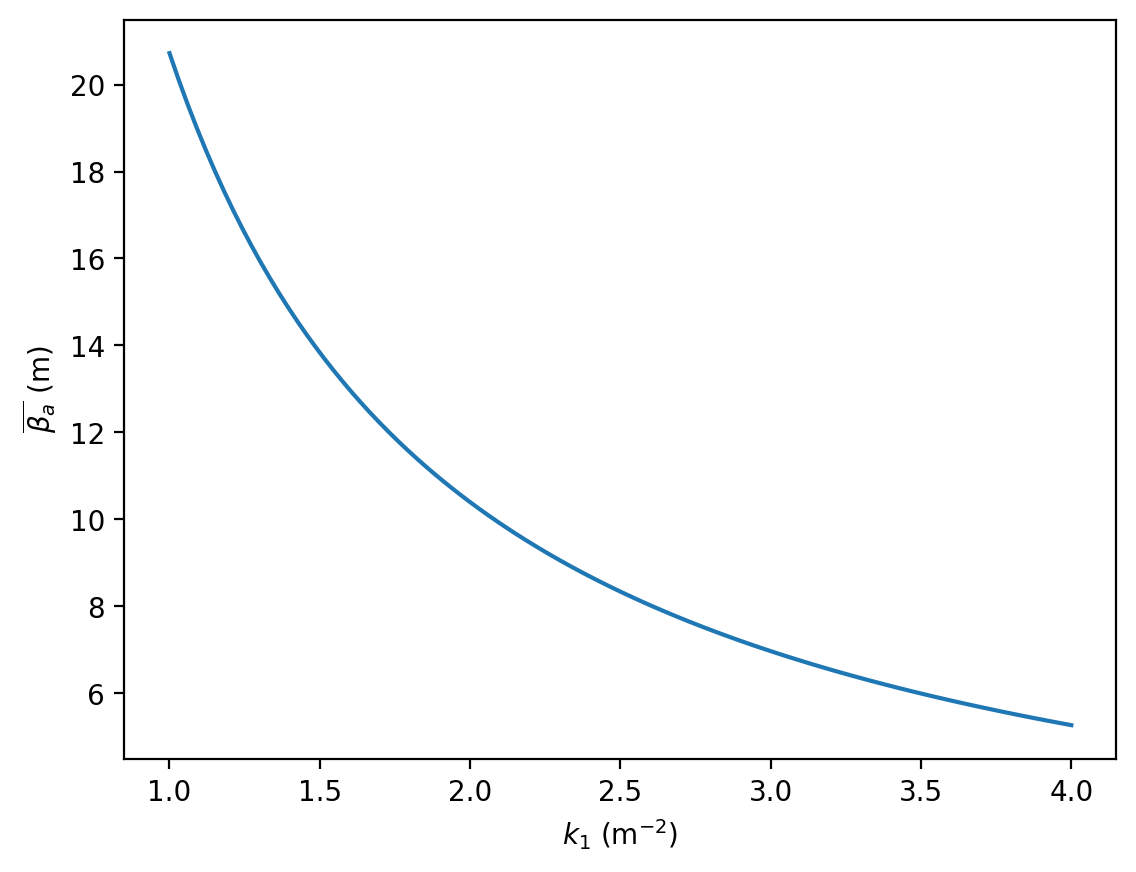

In [20]:
k1vec = np.linspace(1, 4, 100)

results = []
for k1 in k1vec:
    res = set_k1(k1)
    results.append(res)

fix, ax = plt.subplots()
ax.plot(k1vec, np.array([res['average_beta_a'] for res in results]))
ax.set_xlabel(r'$k_1$ (m$^{-2}$)')
ax.set_ylabel(r'$\overline{\beta_a}$ (m)')

## Smallest average beta function

<div class="alert alert-block alert-info">
    
**Task 1:**

Find the $k_1$ that gives the smallest average beta function. 

- What is the corresponting phase advance?

- What are the corresponding matched Twiss parameters?
        
</div>

## 2D Stability plot

<div class="alert alert-block alert-info">
    
**Task 2:**

Make a 2D stability ("necktie") plot similar to the slides
        
</div>

## Add undulators

<div class="alert alert-block alert-info">
    
**Task 3:**

Add undulators (`WIGGLER` elements in Bmad) to this FODO lattice with some strength, and tune the quadrupole strengths to give similar beta functions in both planes.
        
</div>